# Upwelling Detection Demo using LSTM Model

**Packages Explanation**


---


* **xarray**: xarray makes working with labelled multi-dimensional arrays simple and efficient.
* **pickle**: pickle allows serializing and de-serializing a Python object structure, it's used to store fixed points from two buffers (100km away from coast and 300 km away from coast) in our case.
* **datetime**: datetime module supplies classes for manipulating dates and times.
* **numpy & pandas**: provide high-performance, easy-to-use data structures and data analysis tools.
* **pyplot**: provides visualization for our notebook.
* **Sequential**: a linear stack of layers in the neural network.
* **LSTM & Dense**: types of layers in a neural network.
* **train_test_split**: split arrays into random train and test subsets.


**Tutorials / Videos for Image Classification**

* [Tensorflow Image Classification](https://www.tensorflow.org/tutorials/images/classification)
* [Neural Network](https://www.youtube.com/watch?v=aircAruvnKk&t=1004s)
* [RNN Model Tutorial](https://www.youtube.com/watch?v=lWkFhVq9-nc)
* [Efficientnet (CNN) Paper walkthrough](https://www.youtube.com/watch?v=_OZsGQHB41s&t=513s)

In [6]:
import xarray as xr
import pickle
import datetime
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split

**Data Selection**

We are using **2014-07's** data for our demo, this dataset contains **hourly data** from 2014-07-01 to 2014-07-31, and has longitude ranges from 0 to 359.8 and latitude ranges from 90 to -90. Since latitude is ranked in descending order, we should keep in mind our slicing for latitude also need to be in descending order. Data from a single month cannot be enough for model training in order to solve the upwelling prediction task, but it will provide faster runtime when you run the training chunk.

In [7]:
ds = xr.open_dataset('/home/jovyan/shared/data_sst/201407_sea_surface_temperature.nc')

In [8]:
# This shows the details of our dataset
ds

<xarray.Dataset>
Dimensions:                  (lon: 1440, lat: 721, time0: 744)
Coordinates:
  * lon                      (lon) float32 0.0 0.25 0.5 ... 359.2 359.5 359.8
  * lat                      (lat) float32 90.0 89.75 89.5 ... -89.75 -90.0
  * time0                    (time0) datetime64[ns] 2014-07-01 ... 2014-07-31...
Data variables:
    sea_surface_temperature  (time0, lat, lon) float32 ...
Attributes:
    source:       Reanalysis
    institution:  ECMWF
    tilte:        ERA5 forecasts

Instead of having hourly data, we need daily data for our task, thus we take 9AM's data for each day in our dataset. The resullt of printing `sst_data.shape` is `(31, 101, 41, 1)`, here is the explanation:
* **31** indicates we have 31 data samples here, corresponding to the 31 days in our month.
* **101, 41**: The number of data points in latitude and longitude.
* **1**: The channel number of our data. In conventional image classification task, there will be 3 channels (red, green, blue). In our case, sst takes only one channel.


In [9]:
# Create a slice for latitudes from 25 to 0
lats = slice(25, 0)
# Create a slice for longitudes from 70 to 80
lons = slice(70, 80)

# Generate a list of daily datetime points from July 1, 2014 to July 31, 2014 at 9:00:00
time_points = pd.date_range(start='2014-07-01T09:00:00', end='2014-07-31T09:00:00', freq='D')
# Select data from the xarray Dataset ds for the defined time points
ds_selected_time = ds.sel(time0=time_points, method='nearest')
# Select data from the ds_selected_time for the defined longitude and latitude range
ds_selected = ds_selected_time.sel(lon=lons, lat=lats)

# Extract the sea surface temperature data from the selected dataset
sst_data = ds_selected['sea_surface_temperature'].values

# Add a new axis to the end of the array using np.expand_dims
# This is generally done when the model expects input data with a specific shape
sst_data = np.expand_dims(sst_data, axis=-1)

print(sst_data.shape)

(31, 101, 41, 1)


**Sample Visualization**

This chunk of code selects a specific day from the dataset (in this case, the index is set to 0, referring to the first day) and retrieves the sea surface temperature data for that day. It then removes the last dimension of the data in order to plot in 2D.

In order to ensure the image is represented correctly, it flips the data along the first axis because matplotlib places the (0,0) point at the top left by default, while our data is ordered from North to South, and West to East.

Then, it retrieves the corresponding latitude and longitude values. Next, it creates a new figure and plots the data for the selected day onto the image, using the 'viridis' color map. The origin='lower' argument ensures that the origin of the image is at the bottom left, and the extent parameter sets the bounds of the image.

A colorbar is added, indicating the range of sea surface temperature values.

Finally, it sets the labels for the x-axis and y-axis to be the longitude and latitude, respectively.

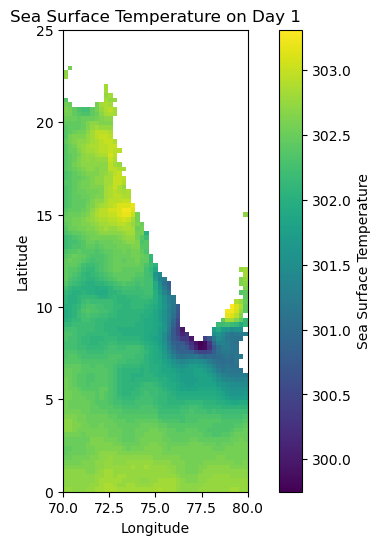

In [15]:
# Choose one day of data
day_index = 0  # choose the day
day_data = sst_data[day_index]

# Remove the last dimension
day_data = np.squeeze(day_data)

# Flip the data along the first axis
day_data = np.flipud(day_data)

# Get the lat and lon values
lat_values = ds_selected.lat.values
lon_values = ds_selected.lon.values

# Create the figure
plt.figure(figsize=(8, 6))

# Plot the data of the day
plt.imshow(day_data, cmap='viridis', origin='lower', extent=[lon_values.min(), lon_values.max(), lat_values.min(), lat_values.max()])

# Add a colorbar
plt.colorbar(label='Sea Surface Temperature')

# Set the labels for the x and y axes
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Set the title
plt.title('Sea Surface Temperature on Day {}'.format(day_index+1))

# Show the plot
plt.show()

**Labels Processing**

The script initially opens a NetCDF dataset that contains Sea Surface Temperature (SST) difference values and converts it to a pandas DataFrame for easier manipulation.

A new column 'entry_id' is created, which enumerates each entry within each date. This means for each date, an incremental number is added to each row.

The script then filters the DataFrame to only include rows where 'entry_id' is 22, 23, or 24. This effectively narrows down the dataset to specific time slots in the day.

Next, a new column 'label' is created. If the SST difference value in a row is below a specified threshold, the label is set to 1, indicating an upwelling event; otherwise, it is set to 0, indicating no upwelling.

Finally, the script groups the data by date, and checks if all labels in a group (i.e., a day) are 1, indicating that all time slots experienced upwelling. If that is the case, the label for the entire group is set to 1; otherwise, it's set to 0. This results in a series of daily labels indicating whether an upwelling event occurred on that day or not.

In [10]:
# Details of the origianl dataset for labelling
temp = xr.open_dataset('/home/jovyan/shared/sst_diff/201407_sst_diff.nc')
temp

<xarray.Dataset>
Dimensions:   (index: 1302)
Coordinates:
  * index     (index) int64 0 1 2 3 4 5 6 ... 1295 1296 1297 1298 1299 1300 1301
    time      (index) datetime64[ns] ...
    lat       (index) float64 ...
    lon       (index) float64 ...
Data variables:
    SST_Diff  (index) float32 ...

In [32]:
# Convert the dataset to a pandas DataFrame
temp_df = temp.to_dataframe()

# Reset index to create 'time' column
temp_df = temp_df.reset_index()

# Create a new column 'entry_id' which enumerates each entry within each date
temp_df['entry_id'] = temp_df.groupby('time').cumcount()

# Filter dataframe for rows where 'entry_id' is 22 and 23
filtered_df = temp_df[temp_df['entry_id'].isin([22,23])]

filtered_df

,index,time,lat,lon,SST_Diff,entry_id
22,22,2014-07-01 09:00:00,8.845619,76.132102,-1.6875,22
23,23,2014-07-01 09:00:00,10.738776,75.474440,-0.6875,23
64,64,2014-07-02 09:00:00,8.845619,76.132102,-2.0000,22
65,65,2014-07-02 09:00:00,10.738776,75.474440,-0.9375,23
106,106,2014-07-03 09:00:00,8.845619,76.132102,-1.8750,22
...,...,...,...,...,...,...
1199,1199,2014-07-29 09:00:00,10.738776,75.474440,-1.5625,23
1240,1240,2014-07-30 09:00:00,8.845619,76.132102,-1.2500,22
1241,1241,2014-07-30 09:00:00,10.738776,75.474440,-1.5000,23
1282,1282,2014-07-31 09:00:00,8.845619,76.132102,-1.1875,22


In [33]:
# Create a label column - set to 1 if SST_Diff > threshold, else set to 0
threshold = -1
filtered_df['label'] = np.where(filtered_df['SST_Diff'] < threshold, 1, 0)

# Group by 'time' and check if all 'label' in a group is 1, if so, set group_label to 1, else 0
group_labels = filtered_df.groupby('time')['label'].apply(lambda x: 1 if x.sum() == 2 else 0)

print(group_labels)

time
2014-07-01 09:00:00    0
2014-07-02 09:00:00    0
2014-07-03 09:00:00    1
2014-07-04 09:00:00    1
2014-07-05 09:00:00    1
2014-07-06 09:00:00    1
2014-07-07 09:00:00    1
2014-07-08 09:00:00    1
2014-07-09 09:00:00    1
2014-07-10 09:00:00    1
2014-07-11 09:00:00    1
2014-07-12 09:00:00    1
2014-07-13 09:00:00    1
2014-07-14 09:00:00    1
2014-07-15 09:00:00    1
2014-07-16 09:00:00    1
2014-07-17 09:00:00    1
2014-07-18 09:00:00    1
2014-07-19 09:00:00    1
2014-07-20 09:00:00    1
2014-07-21 09:00:00    1
2014-07-22 09:00:00    1
2014-07-23 09:00:00    1
2014-07-24 09:00:00    1
2014-07-25 09:00:00    1
2014-07-26 09:00:00    1
2014-07-27 09:00:00    1
2014-07-28 09:00:00    1
2014-07-29 09:00:00    1
2014-07-30 09:00:00    1
2014-07-31 09:00:00    1
Name: label, dtype: int64


/tmp/ipykernel_371/2846083446.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['label'] = np.where(filtered_df['SST_Diff'] < threshold, 1, 0)


**LSTM Introduction**
LSTM (Long Short Term Memory) models are a special type of Recurrent Neural Network (RNN) that work well with sequential data. In LSTM, the hidden state is actually updated at each time step, and the hidden state at each time step depends on the current input and the hidden state at the previous time step. This continuous update process enables the hidden state to memorize and capture long-term dependencies in the input sequence.

Consider a simple example: Suppose we are using an LSTM model to process a piece of natural language text, say a sentence: "The cat, which already ate ..., is full". When we get to the "is full" part, we need to understand that "the cat" is full, not anything else. However, there may be many other words between "the cat" and "is full", which may cause problems in some models, because they may not be able to effectively remember that long-term information.

However, the hidden state of LSTM has the ability to remember. When it processes "is full", its hidden state may still "remember" "the cat" that appeared earlier, and thus be able to correctly understand the meaning of the sentence. This is because the hidden state of LSTM can remember or forget information in a longer-term way than ordinary RNN, thanks to the special gating mechanism of LSTM (including forget gate, input gate, output gate). This mechanism allows us to do possible predictions of upwelling, but in this notebook we just focused on the detection that can also certainly be conducted using other CNN or RNN models.

**LSTM Training Session**

This script takes the prepared labels and the sea surface temperature (SST) data and proceeds with preparing the data for machine learning.

The SST data, originally in a 3D array (time, longitude, latitude), is first "flattened" along the spatial dimensions. This results in a 2D array (time, features) where each time point now has a single-dimensional array of SST values. The np.nan_to_num function is used to replace any NaN values in the dataset with 0.0.

The script then divides the SST data and corresponding labels into a training set (80% of the data) and a test set (20% of the data).

Before being fed into the LSTM model, the SST data is reshaped one more time to have a 3D structure (samples, features, timesteps) where timesteps is 1 as each sample represents SST data from a single day.

Next, an LSTM model is defined using Keras. The model consists of an LSTM layer with 50 units and a 'relu' activation function, followed by a dense layer with a sigmoid activation function, suitable for binary classification.

The model is compiled with the Adam optimizer and binary cross-entropy loss function, suitable for a binary classification problem. It is then trained on the training set for 50 epochs.

When the LSTM model receives input data, it processes the data in order of time steps. That is, for each sample, the model will first process the data for the first time step, then the data for the second time step, and so on until all time steps have been processed. In our case, since there is only one set of SST data per sample (that is, only one time step), the LSTM model will process all the data for each sample at once.

As the data is processed at each time step, the LSTM model will update its internal hidden state, which contains the information the model has learned from the data it has processed. This enables the model to take into account information from previous time steps of a sample when processing subsequent time steps of that sample.

After processing all time steps of a sample, the model will output a value. In our case, this value is calculated by a dense layer with a sigmoid activation function, so it ranges between 0 and 1. This value can be interpreted as the probability predicted by the model, that is, the probability that the sample belongs to the positive class. If this value is greater than 0.5, then the model will predict the sample as a positive class, otherwise it will predict a negative class.

In [29]:
labels = group_labels.values

sst_data = np.squeeze(sst_data)

# Flatten the spatial dimensions of the data
sst_data = sst_data.reshape((sst_data.shape[0], -1))

sst_data = np.nan_to_num(sst_data, nan=0.0)

# Split the data into training set and test set
X_train, X_test, y_train, y_test = train_test_split(sst_data, labels, test_size=0.2, random_state=42)

# Reshape input for LSTM [samples, features, timesteps]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Define LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(Dense(1, activation='sigmoid'))  # Use sigmoid activation function for binary classification
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])  # Use binary crossentropy as loss function for binary classification

# Fit model
model.fit(X_train, y_train, epochs=50, verbose=0)

# Evaluate model
loss, accuracy = model.evaluate(X_test, y_test)

print(f"Accuracy: {accuracy}")

1/1 [==============================] - 0s 442ms/step - loss: nan - accuracy: 0.0000e+00
Accuracy: 0.0


In [26]:
day_index = 15
day_data = sst_data[day_index].reshape(1, -1, 1)
prediction = model.predict(day_data)
prediction
# predicted_class = 1 if prediction > 0.5 else 0
# print("Predicted class for day {}: {}".format(day_index, predicted_class))

1/1 [==============================] - 0s 389ms/step


array([[nan]], dtype=float32)